### Imports and data load

In [109]:
## imports (use requirements.txt for dependencies)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import sklearn.metrics as metrics
import tensorflow as tf

In [110]:
# Read and show head of input data
df_input = pd.read_csv('../resources/inputs/depression_data.csv')
df_input.head()

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


### Basic Data Checks/Cleaning
The input data is fully populated and set to reasonable data types.

The "Name" field has some duplication. In the context of the problem I have assumed this is a reflection of forename/surname pairs generated from a limited list, in a real-world situation high duplication should be checked to ensure patients are not appearing multiple times

In [111]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

In [112]:
df_input.nunique()

Name                            196851
Age                                 63
Marital Status                       4
Education Level                      5
Number of Children                   5
Smoking Status                       3
Physical Activity Level              3
Employment Status                    2
Income                          405282
Alcohol Consumption                  3
Dietary Habits                       3
Sleep Patterns                       3
History of Mental Illness            2
History of Substance Abuse           2
Family History of Depression         2
Chronic Medical Conditions           2
dtype: int64

In [113]:
df_input.duplicated().any()


False

### EDA and Feature engineering
- Name is removed as it is unlikely to be a useful predictor.
- True/False columns are converted to numerical
- Square root of income is taken to reduce right-skew
- Analysis of correlation between features

In [115]:
# drop 'name' as it is unlikely to be a useful feature
data = df_input.drop(['Name'], axis = 1)
# convert binary columns to numeric
data['History of Mental Illness'] = np.where(data["History of Mental Illness"]=='Yes', 1, 0)
data['History of Substance Abuse'] = np.where(data["History of Substance Abuse"]=='Yes', 1, 0)
data['Family History of Depression'] = np.where(data["Family History of Depression"]=='Yes', 1, 0)
data['Chronic Medical Conditions'] = np.where(data["Chronic Medical Conditions"]=='Yes', 1, 0)
# create children flag
data['Has Children Flag'] = data['Number of Children'].where(data['Number of Children']==0, 1)
# reduce skew in income variable
data['Income Square Root'] = np.sqrt(data['Income'])
# try interaction terms on possible useful variables
data['Divorced_Children'] = np.where((data['Marital Status']=='Divorced') & data['Has Children Flag']==1, 1, 0)
data['Widowed_Children'] = np.where((data['Marital Status']=='Widowed') & data['Has Children Flag']==1, 1, 0)
data['Unhealthy_Lifestyle_All'] = np.where((data['Alcohol Consumption']=='High')&(data['Sleep Patterns']=='Poor')&(data['Dietary Habits']=='Unhealthy')&(data['Physical Activity Level']=='Sedentary'), 1, 0)
data['Unhealthy_Lifestyle_Sum'] = np.where(data['Alcohol Consumption']=='High', 1, 0) + np.where(data['Sleep Patterns']=='Poor', 1, 0) + np.where(data['Dietary Habits']=='Unhealthy', 1, 0) + np.where(data['Physical Activity Level']=='Sedentary', 1, 0) + np.where(data['Smoking Status']=='Current', 1, 0)
data['Unemployed_ChronicCondition'] = np.where((data['Employment Status']=='Unemployed')&(data['Chronic Medical Conditions']==1), 1, 0)

data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,413768.0,NaN,NaN,NaN,49.000713,18.158759,18.0,33.0,49.0,65.0,80.0
Marital Status,413768,4,Married,240444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,413768,5,Bachelor's Degree,124329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number of Children,413768.0,NaN,NaN,NaN,1.298972,1.237054,0.0,0.0,1.0,2.0,4.0
Smoking Status,413768,3,Non-smoker,247416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Physical Activity Level,413768,3,Sedentary,176850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employment Status,413768,2,Employed,265659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,413768.0,NaN,NaN,NaN,50661.707971,40624.100565,0.41,21001.03,37520.135,76616.3,209995.22
Alcohol Consumption,413768,3,Moderate,173440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dietary Habits,413768,3,Unhealthy,170817,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# identify numerical / categorical columns
cat_cols=data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()

### Review distribution and skew of numeric features

Age
Skew : 0.0


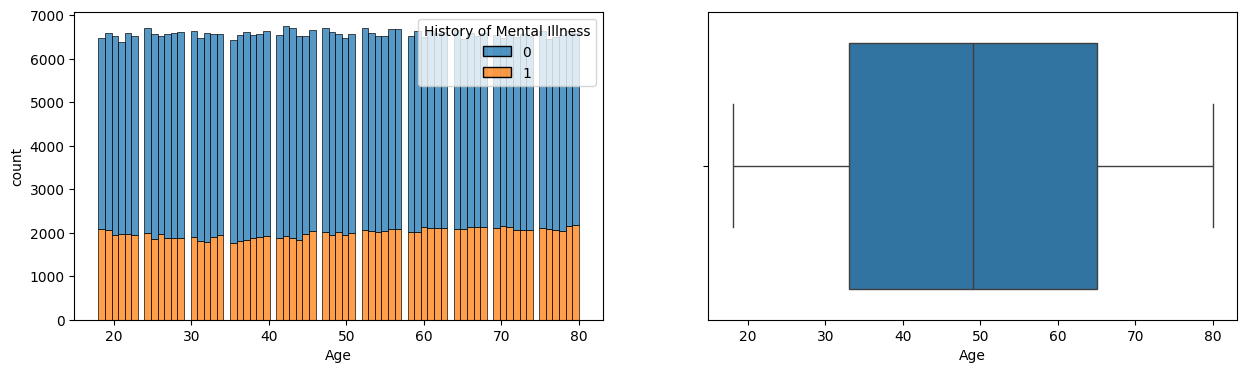

Number of Children
Skew : 0.43


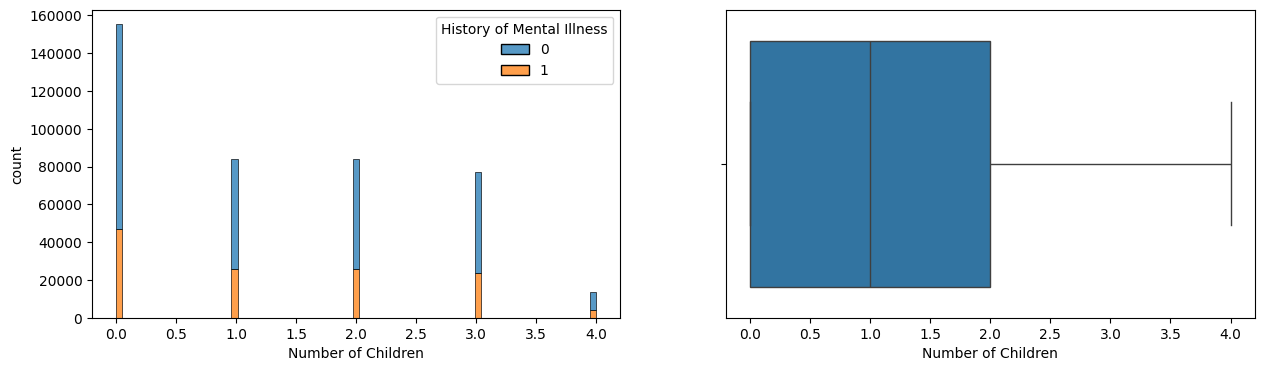

Income
Skew : 1.09


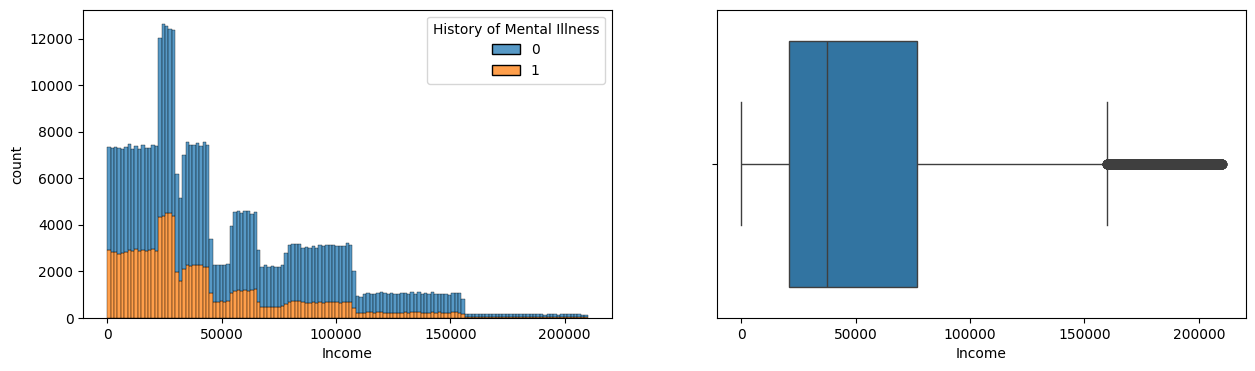

History of Mental Illness
Skew : 0.85


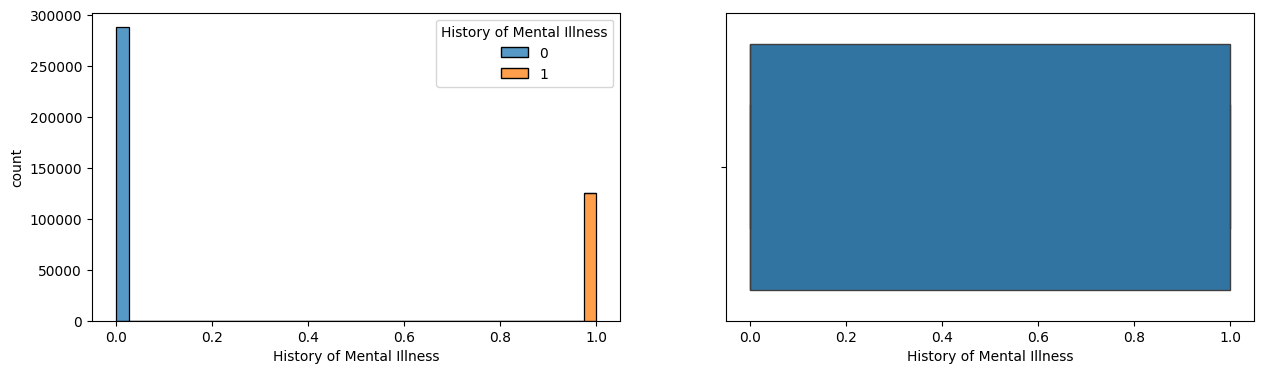

History of Substance Abuse
Skew : 0.81


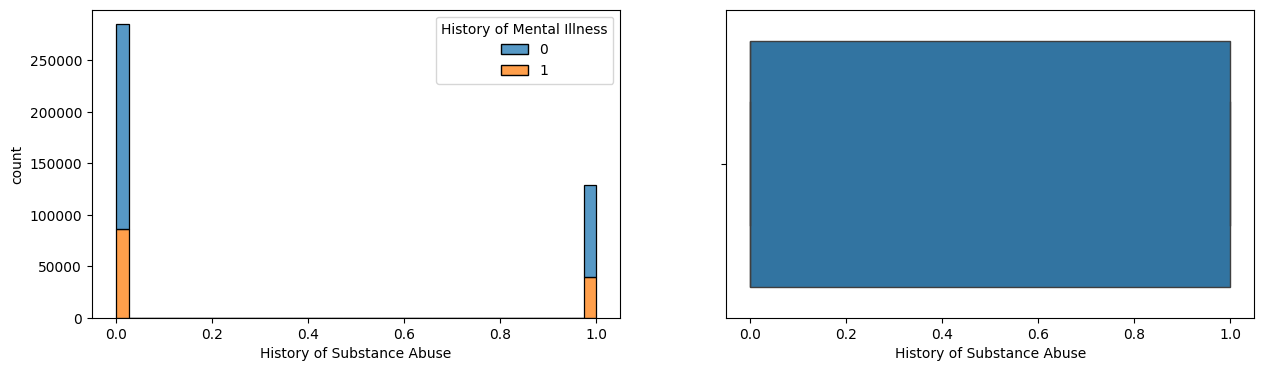

Family History of Depression
Skew : 1.04


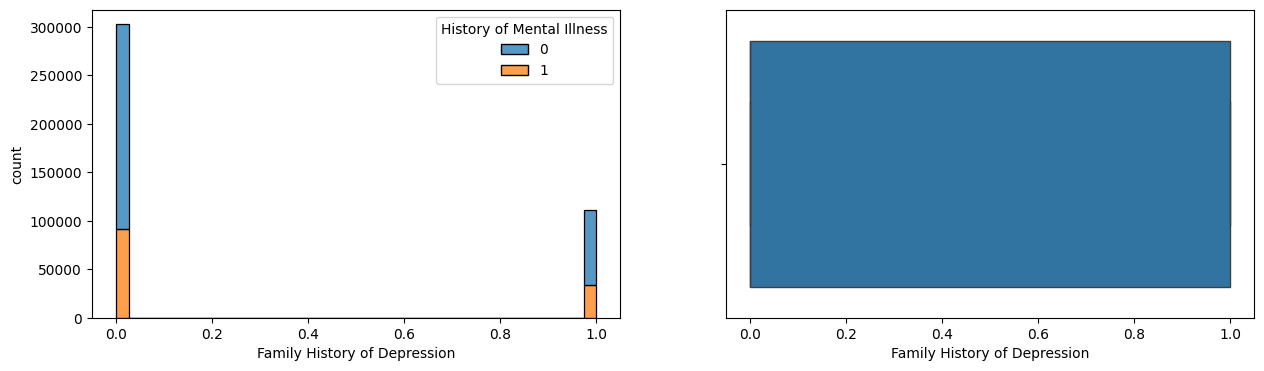

Chronic Medical Conditions
Skew : 0.73


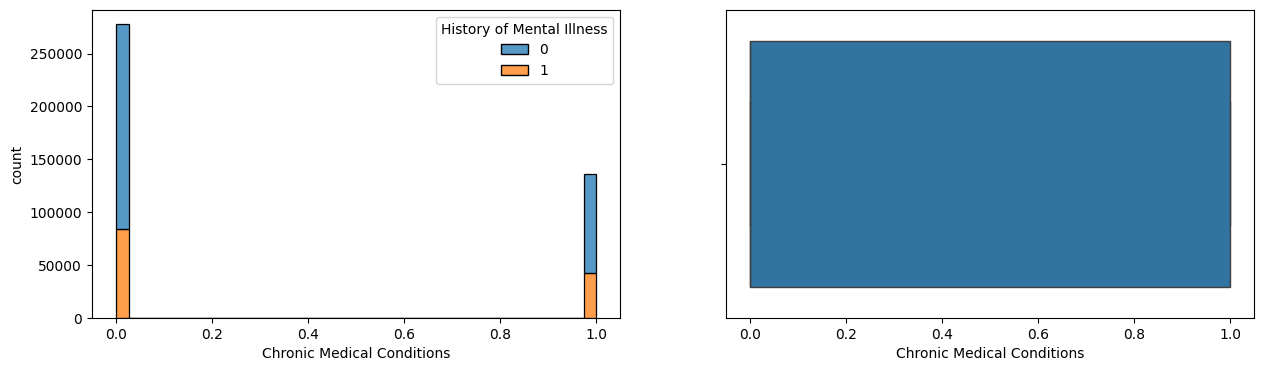

Has Children Flag
Skew : -0.52


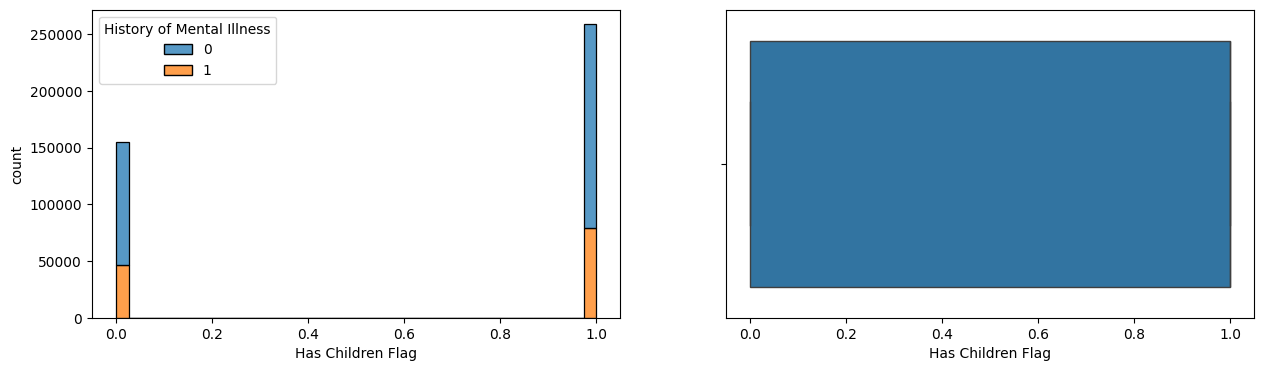

Income Square Root
Skew : 0.26


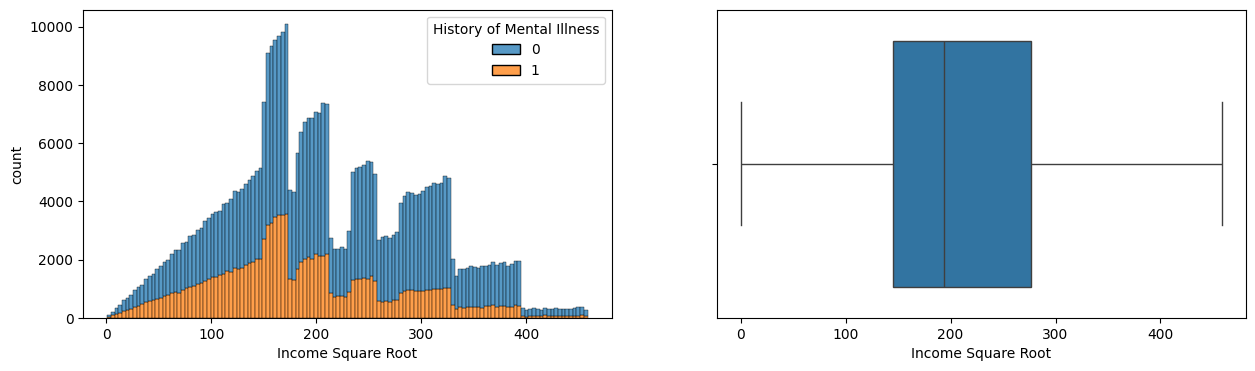

Divorced_Children
Skew : 3.72


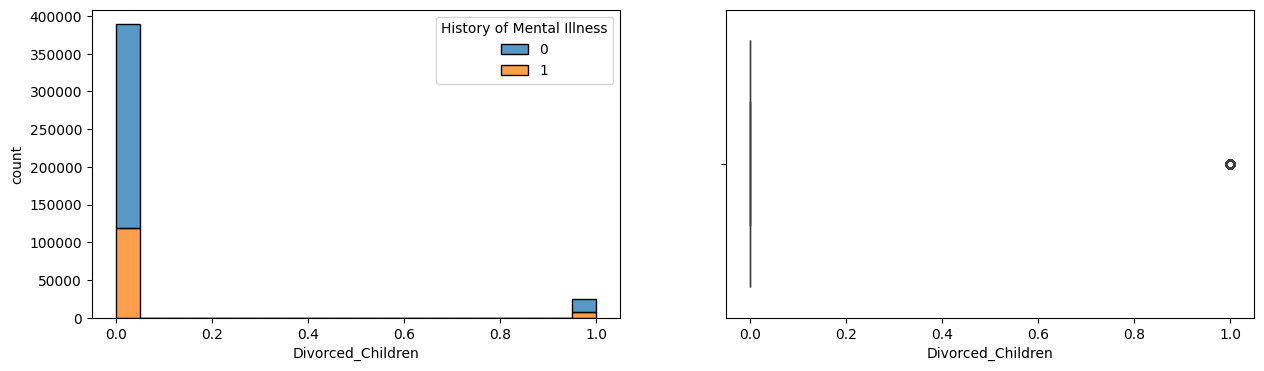

Widowed_Children
Skew : 2.28


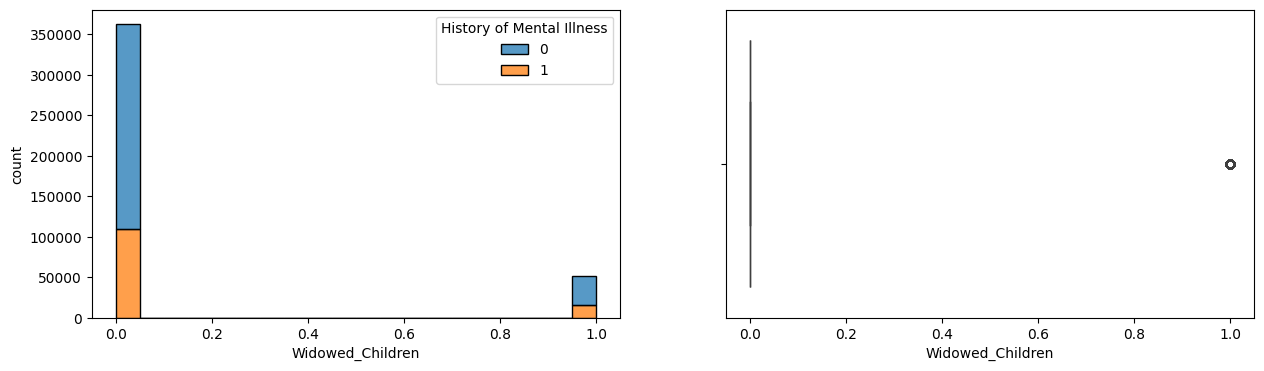

Unhealthy_Lifestyle_All
Skew : 6.12


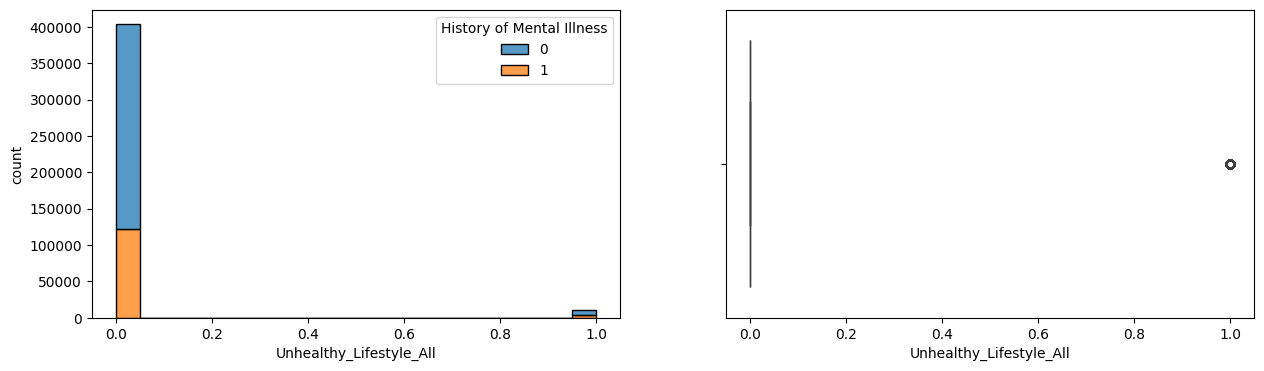

Unhealthy_Lifestyle_Sum
Skew : 0.34


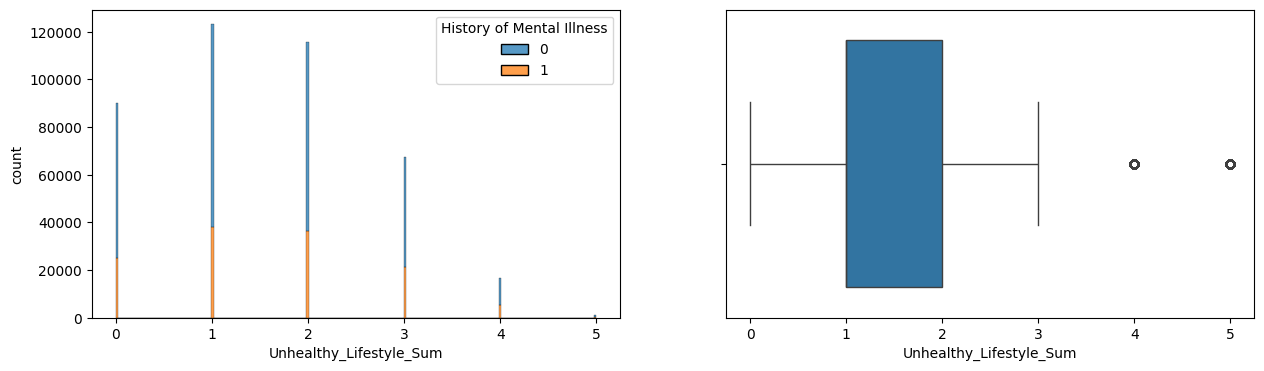

Unemployed_ChronicCondition
Skew : 2.24


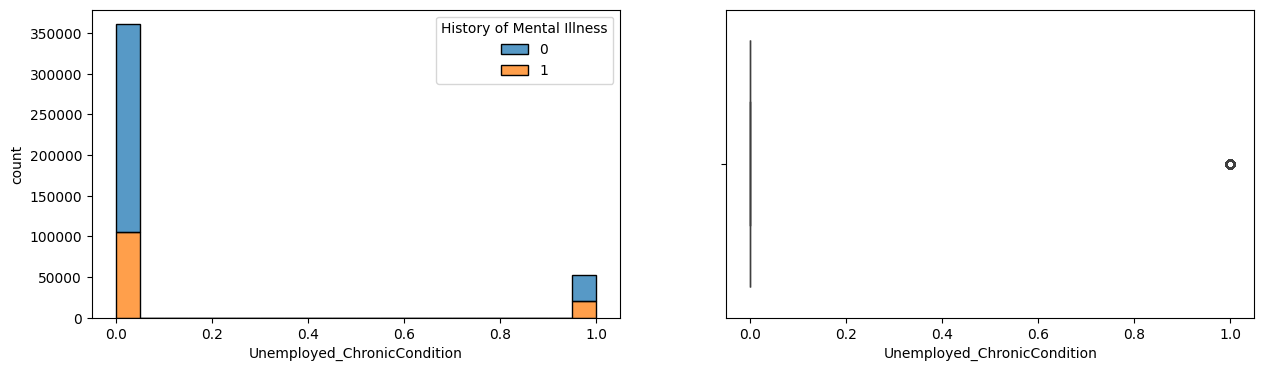

In [88]:
for col in num_cols:
    print(col)
    print('Skew :', round(data[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    # data[col].hist(grid=False)
    sns.histplot(bins='auto', x = col, hue="History of Mental Illness", data=data, multiple='stack');
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

### Review bar plots of categorical features

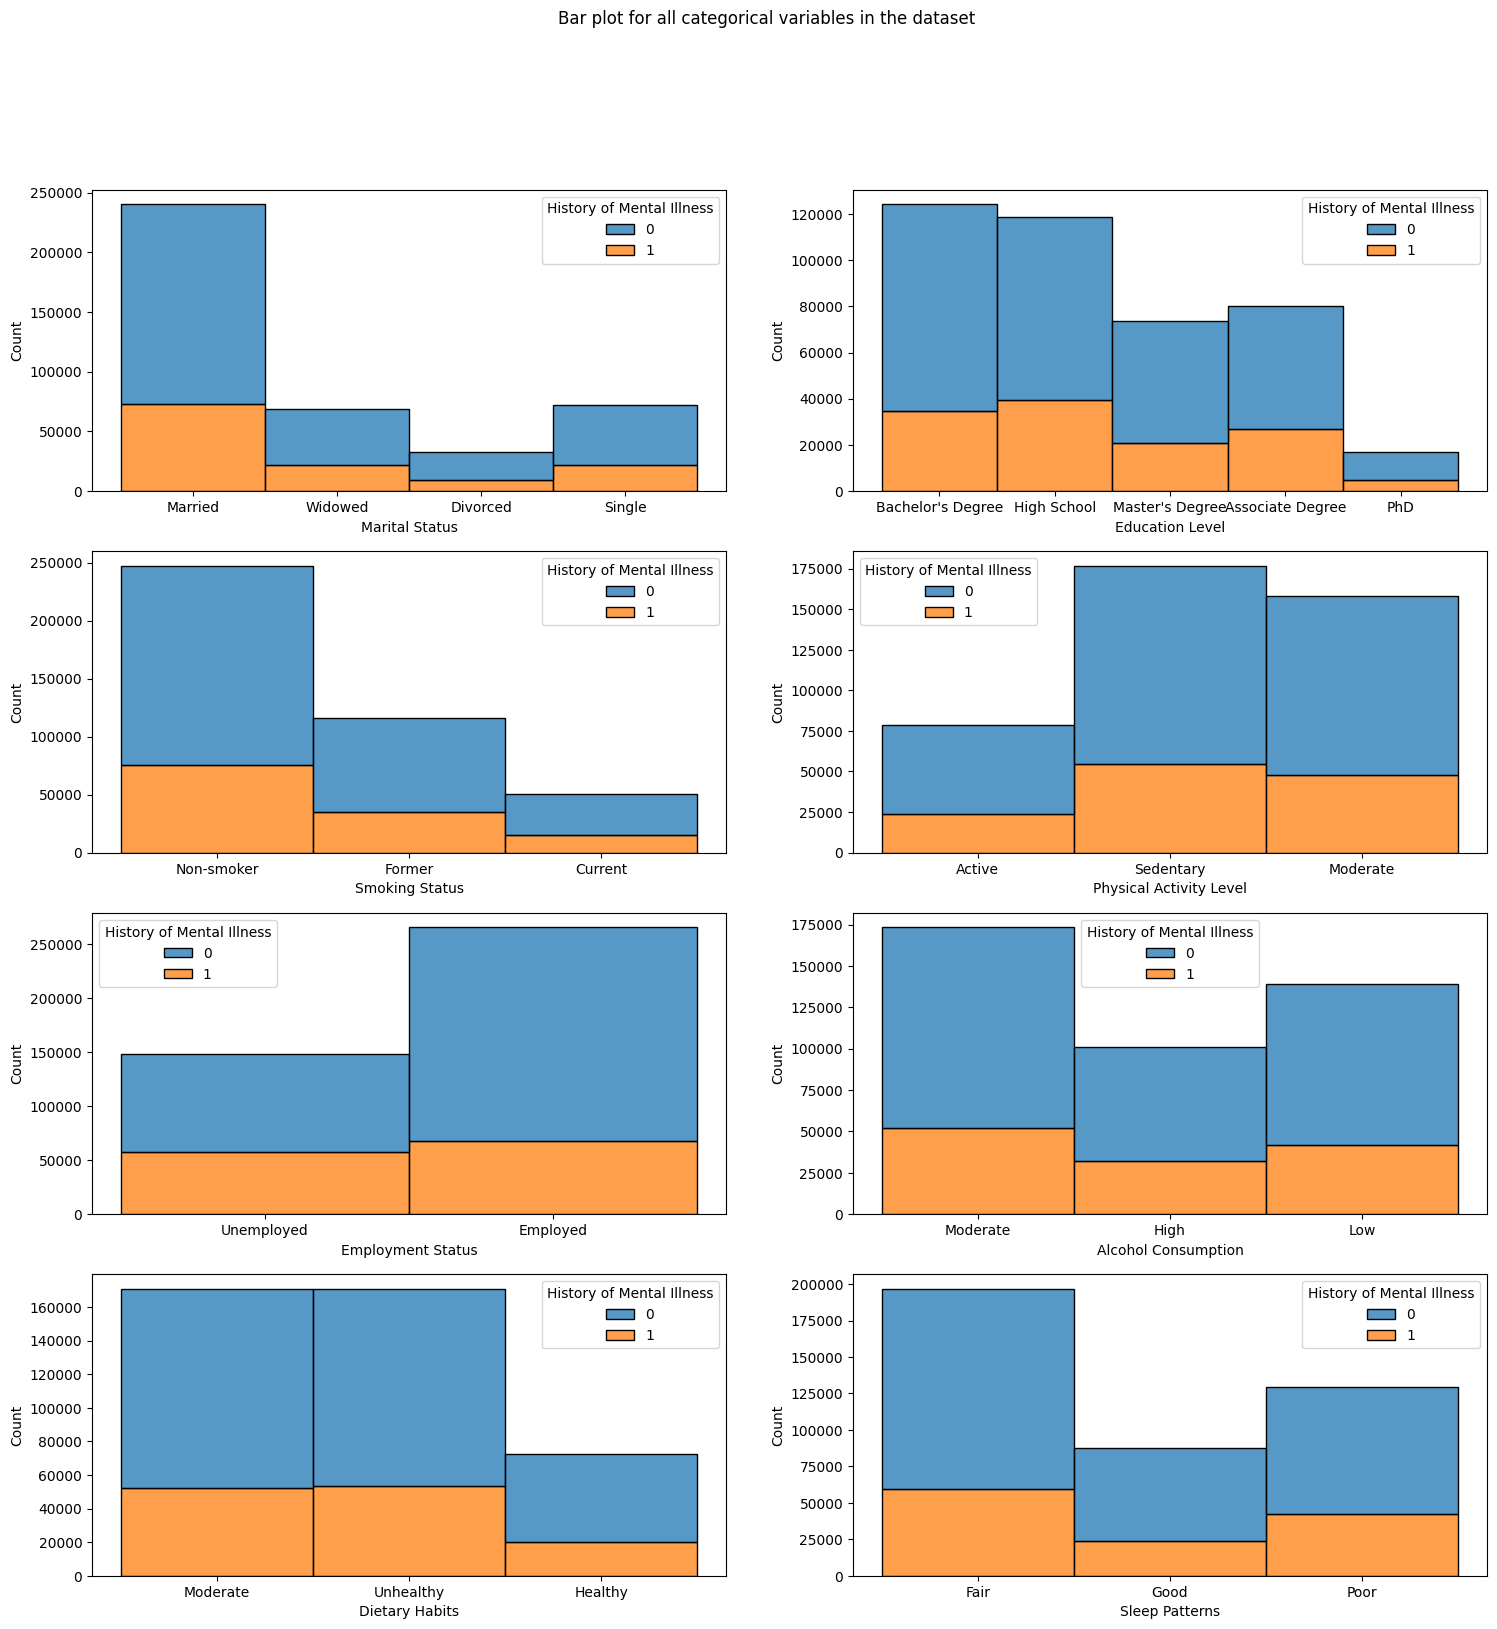

In [89]:
fig, axes = plt.subplots(4, 2, figsize = (18, 18))
fig.suptitle('Bar plot for all categorical variables in the dataset')
for i, col in enumerate(cat_cols):
    sns.histplot(ax = axes[i//2, i%2], binwidth=0.5, x = col, hue="History of Mental Illness", data=data, multiple='stack');

### Review correlation between numerical variables

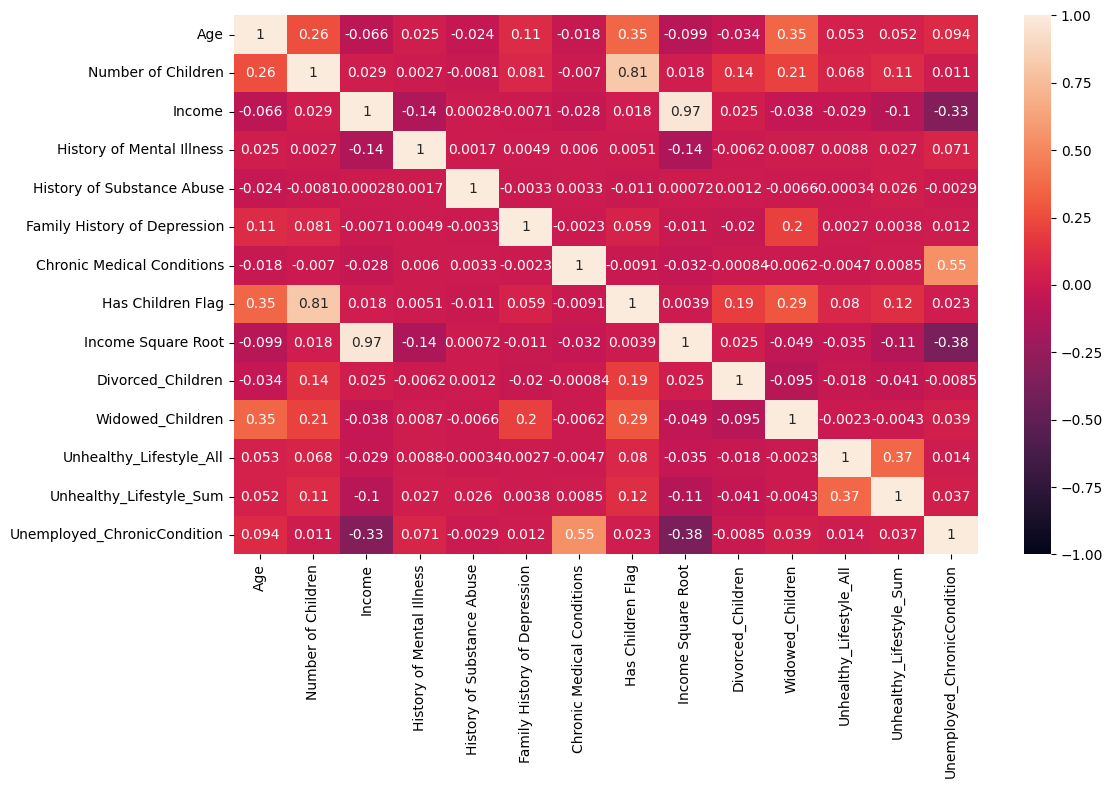

In [90]:
plt.figure(figsize=(12, 7))
sns.heatmap(data[num_cols].corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

### Review correlation to the target variable and select features
- A full feature set is created based only on removing features with high cross-correlation
- A 'reduced features' set is created based on removing variables with low correlation to the target (<0.1), with the aim of preserving performance whilst reducing complexity|

In [ ]:
# one hot encode categorical features
data_onehot = pd.get_dummies(data)
data_onehot[data_onehot.columns[1:]].corr()['History of Mental Illness'][:]

Number of Children                   0.002713
Income                              -0.136805
History of Mental Illness            1.000000
History of Substance Abuse           0.001733
Family History of Depression         0.004887
Chronic Medical Conditions           0.006038
Has Children Flag                    0.005147
Income Square Root                  -0.143059
Divorced_Children                   -0.006201
Widowed_Children                     0.008714
Unhealthy_Lifestyle_All              0.008779
Unhealthy_Lifestyle_Sum              0.027339
Unemployed_ChronicCondition          0.071247
Marital Status_Divorced             -0.006516
Marital Status_Married               0.001821
Marital Status_Single               -0.007040
Marital Status_Widowed               0.009500
Education Level_Associate Degree     0.031231
Education Level_Bachelor's Degree   -0.038089
Education Level_High School          0.036902
Education Level_Master's Degree     -0.024371
Education Level_PhD               

In [ ]:
features = [
    'Age',
    'Marital Status',
    'Education Level',
    # 'Number of Children', ## removed due to high corr to children flag
    # 'Income', ## removed due to high corr to income sqrt
    'Smoking Status', 
    'Physical Activity Level',
    'Employment Status',
    'Alcohol Consumption',
    'Dietary Habits',
    'Sleep Patterns',
    'History of Substance Abuse',
    'Family History of Depression',
    'Chronic Medical Conditions',
    'Has Children Flag',
    'Income Square Root', 
    'Divorced_Children',
    'Widowed_Children', 
    'Unhealthy_Lifestyle_All',
    'Unhealthy_Lifestyle_Sum', 
    'Unemployed_ChronicCondition'
]
target = 'History of Mental Illness'

In [ ]:
# reduced features based on low correlation to target
features_reduced = [
    'Age',
    # 'Marital Status',
    'Education Level',
    # 'Number of Children',
    # 'Income',
    # 'Smoking Status', 
    # 'Physical Activity Level',
    'Employment Status',
    'Alcohol Consumption',
    'Dietary Habits',
    'Sleep Patterns',
    # 'History of Substance Abuse',
    # 'Family History of Depression',
    # 'Chronic Medical Conditions',
    # 'Has Children Flag',
    'Income Square Root', 
    # 'Divorced_Children',
    # 'Widowed_Children', 
    # 'Unhealthy_Lifestyle_All',
    'Unhealthy_Lifestyle_Sum', 
    'Unemployed_ChronicCondition'    
]

## Modelling Exploration
- Trialling Logistic Regression and XGBoost approaches with all features

In [ ]:
# prepare categorical (ie. non-encoded) model inputs
for c in data.columns:
    if data[c].dtype == 'object':
        data[c] = data[c].astype('category')

Xcat = data[features]
ycat = data[target]

Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size=0.2)

In [ ]:
# one-hot-encoded model inputs
X = pd.get_dummies(Xcat)

X_train, X_test, y_train, y_test = train_test_split(X, ycat, test_size=0.2)

# apply Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# function to rapidly evaluate a candidate model (AUC, precision-recall etc)
def quick_eval(mdl, X_t, y_t, nn=False):
    if nn:
        prob = mdl.predict(X_t)
        pred = [1 if e>0.5 else 0 for e in prob]
    else:
        pred = mdl.predict(X_t)
        prob = mdl.predict_proba(X_t)[:,1]
    print('Accuracy:', metrics.accuracy_score(y_t, pred))
    print('Precision:', metrics.precision_score(y_t, pred))
    print('Recall:', metrics.recall_score(y_t, pred))
    print('F1 Score:', metrics.f1_score(y_t, pred))

    fpr, tpr, thresholds = metrics.roc_curve(y_t, prob)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    if not nn:
        display = metrics.PrecisionRecallDisplay.from_estimator(
            mdl, X_t, y_t, name="LinearSVC", plot_chance_level=True
        )
        _ = display.ax_.set_title("2-class Precision-Recall curve")
        plt.show()
    

Accuracy: 0.6972230949561351
Precision: 0.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.0
F1 Score: 0.0


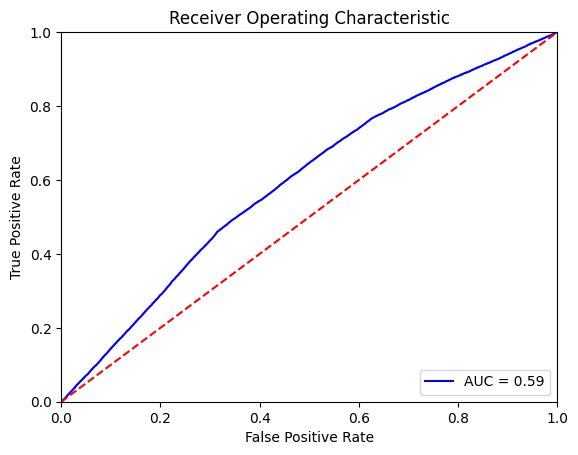

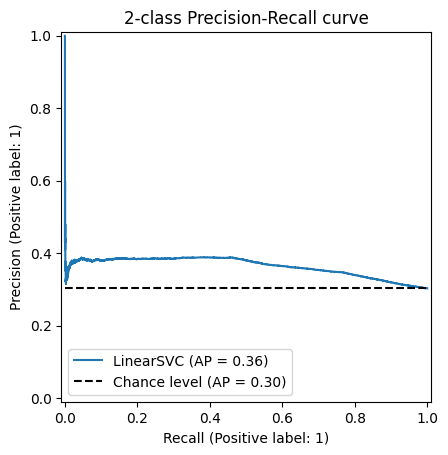

In [ ]:
# try logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

quick_eval(log_reg, X_test, y_test)

Accuracy: 0.6952171496241873
Precision: 0.3407079646017699
Recall: 0.009237782932096298
F1 Score: 0.01798785235944557


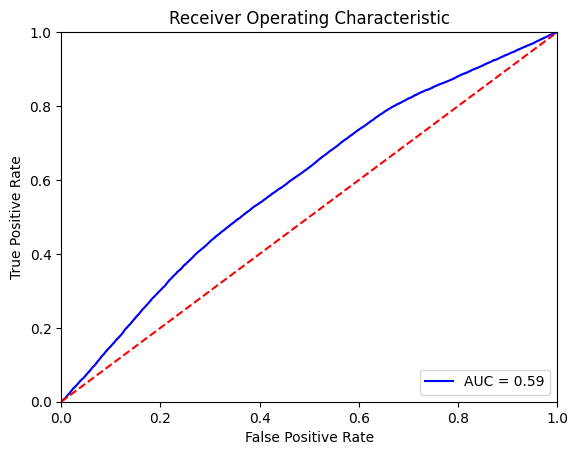

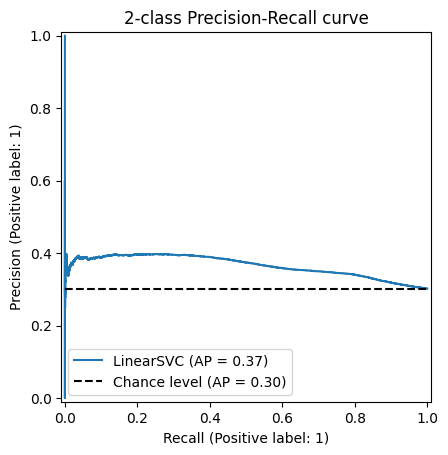

In [ ]:
# try xgboost (feeding features as categorical rather than encoded)
xgb = XGBClassifier(enable_categorical=True)
xgb.fit(Xcat_train, ycat_train)

quick_eval(xgb, Xcat_test, ycat_test)

Accuracy: 0.6468690335210383
Precision: 0.3457466498852447
Recall: 0.18638250319284802
F1 Score: 0.2422010735679278


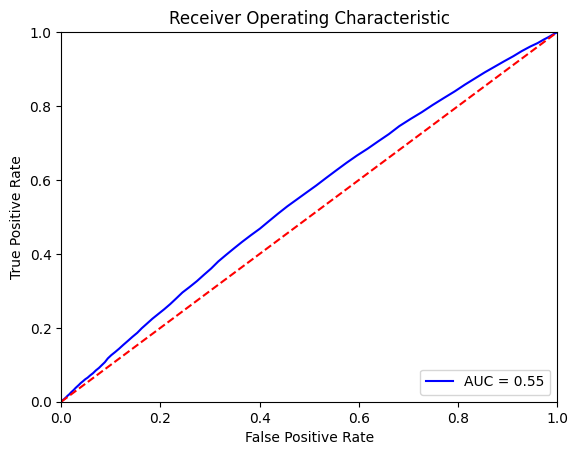

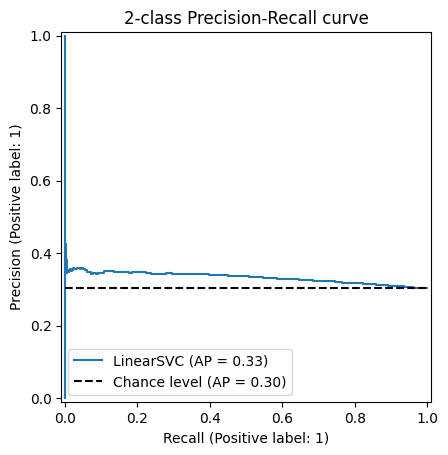

In [ ]:
# try random forest
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

quick_eval(rnd_clf, X_test, y_test)

In [101]:
# try a simple neural network
model = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(128, activation="relu"),
                  tf.keras.layers.Dense(1, activation="sigmoid")
 ])
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])
# Fit the model
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_test, y_test))

model.evaluate(X_test, y_test)

Epoch 1/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.6931 - loss: 0.6055 - val_accuracy: 0.6972 - val_loss: 0.6007
Epoch 2/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6964 - loss: 0.6006 - val_accuracy: 0.6972 - val_loss: 0.5997
Epoch 3/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.6952 - loss: 0.6009 - val_accuracy: 0.6972 - val_loss: 0.6001
Epoch 4/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6947 - loss: 0.6010 - val_accuracy: 0.6972 - val_loss: 0.5995
Epoch 5/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.6942 - loss: 0.6014 - val_accuracy: 0.6972 - val_loss: 0.5999
Epoch 6/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.6958 - loss: 0.5994 - val_accuracy: 0.6972 - val_loss: 0.5997
Epoch 7/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6952 - loss: 0.6001 - val_accuracy: 0.6972 - val_loss: 0.5996
Epoch 8/20
10345/10345 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 

[0.6005565524101257, 0.6970901489257812]

2587/2587 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step
Accuracy: 0.6970901708678735
Precision: 0.44954128440366975
Recall: 0.001955619412515964
F1 Score: 0.003894297635605007


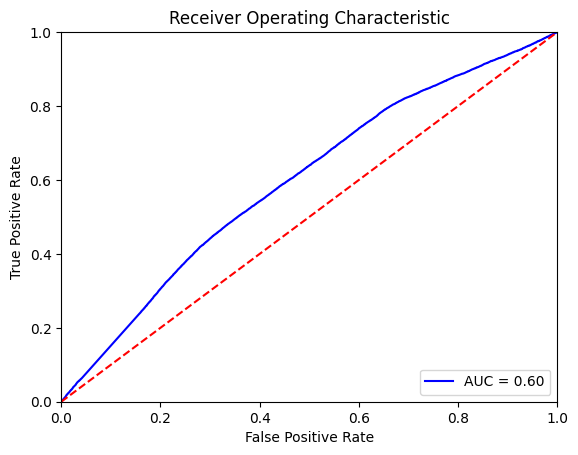

In [102]:
quick_eval(model, X_test, y_test, nn=True)

### Revisiting Logistic Regression
- Alternative approaches seem to have little to no performance benefit
- Does a LR perform worse on a reduced feature set?

In [103]:
# one-hot-encoded data inputs
Xcat = data[features_reduced]
X = pd.get_dummies(Xcat)

X_train, X_test, y_train, y_test = train_test_split(X, ycat, test_size=0.2)

# Feature Scaling for reduced set
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Accuracy: 0.695845518041424
Precision: 0.0
Recall: 0.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Score: 0.0


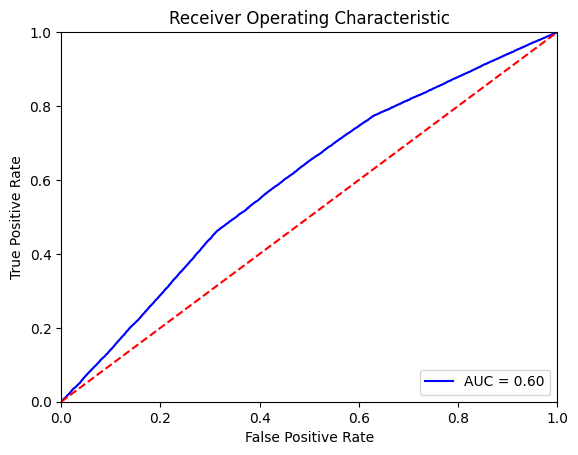

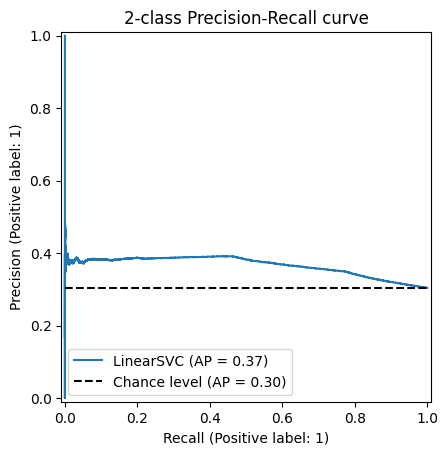

In [104]:
# train another logistic regression on the reduced features
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

quick_eval(log_reg, X_test, y_test)

In [105]:
prob = log_reg.predict_proba(X_test)[:,1]
pred = y_pred = (prob >= 0.3).astype('int')

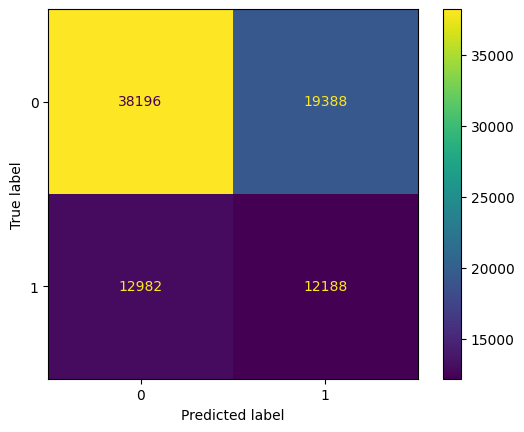

In [106]:
confusion_matrix = metrics.confusion_matrix(y_test,pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [107]:
print(f'Precision: {metrics.precision_score(y_test, pred)}')
print(f'Recall: {metrics.recall_score(y_test, pred)}')
print(f'Accuracy: {metrics.accuracy_score(y_test, pred)}')

Precision: 0.3859893590068406
Recall: 0.48422725466825584
Accuracy: 0.6088406602701985


In [108]:
pd.DataFrame({'Feature':pd.get_dummies(data[features_reduced]).columns,
              'Coefficient':log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
11,Employment Status_Unemployed,0.094748
5,Education Level_Associate Degree,0.040431
7,Education Level_High School,0.026311
3,Unhealthy_Lifestyle_Sum,0.013282
20,Sleep Patterns_Poor,0.005818
16,Dietary Habits_Moderate,0.003995
0,Age,0.001694
2,Unhealthy_Lifestyle_All,0.001094
14,Alcohol Consumption_Moderate,0.000515
18,Sleep Patterns_Fair,0.000203
